# Credit Risk Model using UCI Dataset and Bayesian Optimisation


In [3]:
## Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
## Step 2: Load UCI German Credit Dataset
column_names = [
    "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount", "Savings",
    "EmploymentSince", "InstallmentRate", "PersonalStatusSex", "OtherDebtors",
    "ResidenceSince", "Property", "Age", "OtherInstallmentPlans", "Housing",
    "ExistingCredits", "Job", "LiablePeople", "Telephone", "ForeignWorker", "credit_risk"
]

df = pd.read_csv("german.data", sep=' ', header=None, names=column_names)
df.head()

,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,...,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [11]:
## Step 3: Format Target Column
df['credit_risk'] = df['credit_risk'].map({1: 1, 2: 0})

In [13]:
## Step 4: Encode Categorical Columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

In [15]:
## Step 5: Split Features and Target
X = df.drop('credit_risk', axis=1)
y = df['credit_risk']


In [17]:
## Step 6: Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
## Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
## Step 8: Define Search Space and Model
param_space = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(100, 1000),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 5)
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [25]:
## Step 9: Bayesian Optimisation with BayesSearchCV
opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    n_iter=32,
    scoring='roc_auc',
    cv=5,
    verbose=0,
    random_state=42
)

opt.fit(X_train, y_train)
best_model = opt.best_estimator_

C:\Users\praka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:27:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\praka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:27:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\praka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:27:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\praka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:27:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

In [26]:
## Step 10: Evaluation
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Hyperparameters:", opt.best_params_)
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Hyperparameters: OrderedDict({'colsample_bytree': 0.7443358540027365, 'gamma': 3.640041019072196, 'learning_rate': 0.03138955820557663, 'max_depth': 10, 'n_estimators': 601, 'subsample': 0.5575594048210827})
ROC AUC Score: 0.7926190476190476

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.52      0.56        60
           1       0.81      0.86      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.75      0.76      0.75       200


Confusion Matrix:
[[ 31  29]
 [ 19 121]]


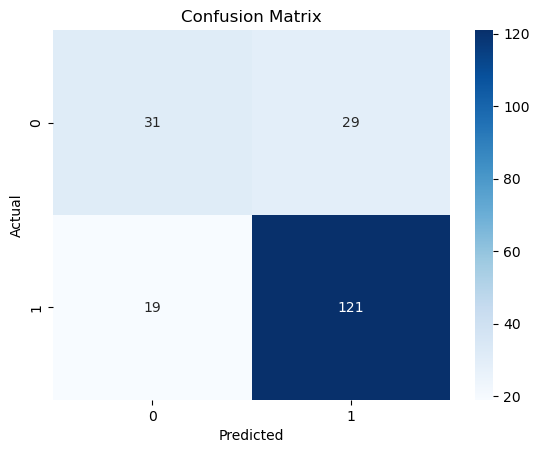

In [29]:
## Step 11: Plot Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()












In [31]:
#Let's understand the accuracy of the outcome

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Print the confusion matrix values
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


True Negatives (TN): 31
False Positives (FP): 29
False Negatives (FN): 19
True Positives (TP): 121

Accuracy:  0.76
Precision: 0.81
Recall:    0.86
F1 Score:  0.83


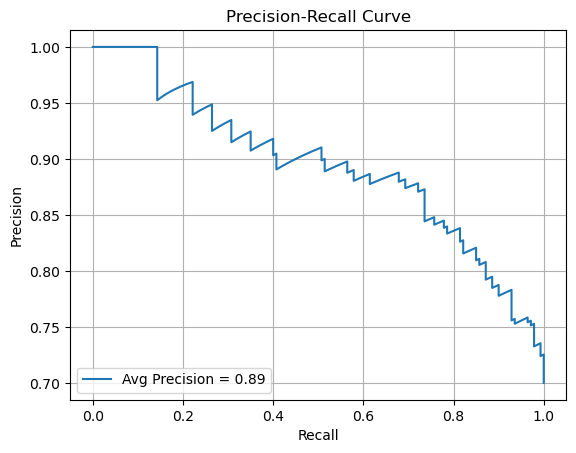

In [35]:
#Precision-Recall curve to understand if the positive class is rate, like predicting loan defaults
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


C:\Users\praka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:41:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


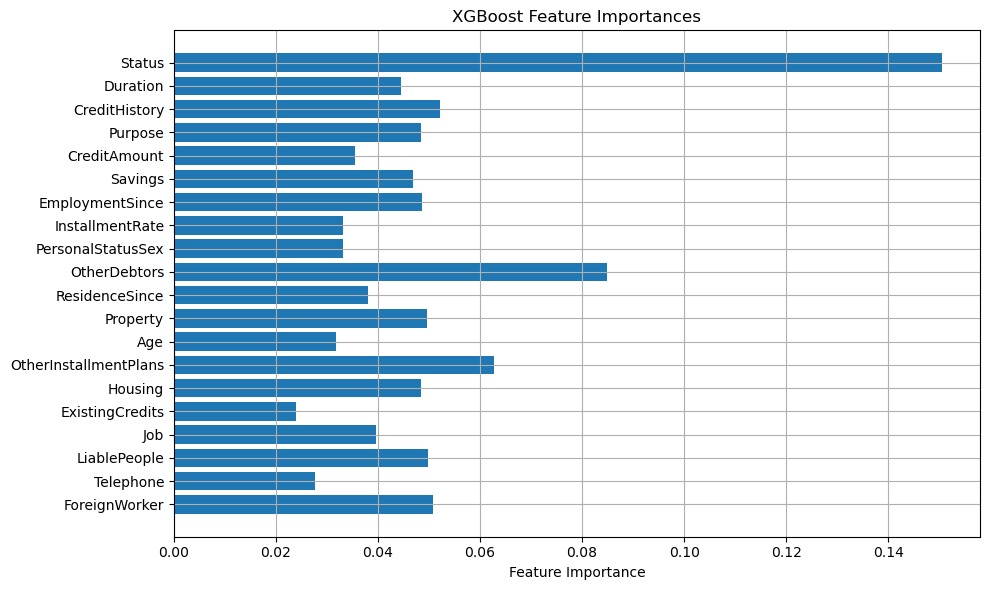

In [39]:
#Feature Importance

# Define and fit the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
